# Coupled Laser Simulations

## TODOs
- How to implement changing injection currents?

## Imports and Defining Global Constants

In [20]:
import numpy as np
import math
import matplotlib.pyplot as plt
from jitcdde import jitcdde, y, t
from numpy import sin, cos
from scipy.fft import rfft, rfftfreq
from scipy.signal import butter, filtfilt
from tqdm import tqdm
import time

In [2]:
# Physical constants
e_charge = 1.602e-19  # Coulombs
c = 3e8               # Speed of light (m/s)

# Laser parameters shared by all lasers
alpha = 3.0           # Linewidth enhancement factor (dimensionless)
g = 1.2e4             # Differential gain coefficient (s^-1)
N_0 = 1.25e8          # Transparency carrier number (dimensionless)
s = 5e-7              # Saturation coefficient (dimensionless)s
gamma = 4.96e11       # Photon decay rate (s^-1)
gamma_e = 6.51e8      # Carrier decay rate (s^-1)
# See Ohtsubo pg. 37 for below details. Numbers for a InGaAsP laser
nu = 3.6              # Refractive index (dimensionless)
nu_e = 4              # Effective refractive index (dimensionless)
l = 250e-6            # Laser length (m)
tau_in = 2 * nu_e * l / c # Round trip time of light in laser cavity (s)

# Typical values for lasers (not necessarily used, but may be referenced for convenience)
wavelength_typ = 655e-9   # Laser wavelength (655 nm)
frequency_typ = c / wavelength_typ  # f = c / λ - QUESTION: shouldn't the index of refraction of the laser medium be inserted in below calculation?
omega_typ = 2 * np.pi * frequency_typ # typical laser frequency in rad/s
I_th = 17.35e-3       # Threshold current (= 17.35mA)
r_0 = (nu - 1) / (nu + 1) # Internal amplitude reflectivity for a cleaved facet (see Ohtsubo pg. 84)

## Define Simulation Functions

In [3]:
# Generates Lang-Kobayashi Differential Equations for a system of lasers of specified parameters
# Returns equations in order: laser #1 real E, laser #1 imaginary E, laser #1 carrier density, laser #2 real E, ...
def generate_equations(num_lasers, omegas, kappas, taus, I_injections):
    # State variables 
    # Each laser has 3 independent variables: real component of E field, imaginary component of E field, and carrier density
    # in total there are num_lasers*3 variables
    E_Rs = [] # Real part of electric field
    E_Is = [] # Imaginary part of electric field
    Ns = [] # Carrier density
    
    for i in range(num_lasers):
        E_Rs.append(y(i * 3))
        E_Is.append(y(i * 3 + 1))
        Ns.append(y(i * 3 + 2))
    
    #print(f"E_Rs: {E_Rs}, E_Is: {E_Is}, Ns: {Ns}")
    
    # Delayed variables are added in the equation itself
    
    # The intensity and gain are dependent on E and N
    intensities = []
    gains = []
    
    # Intensities
    for i in range(num_lasers):
        intensities.append(E_Rs[i]**2 + E_Is[i]**2)
    
    # Net Gains
    for i in range(num_lasers):
        gains.append( (g * (Ns[i] - N_0) / (1 + s * intensities[i])) ) 
    
    # Equations for derivatives
    dE_R_dts = []
    dE_I_dts = []
    dN_dts = []
    
    for j in range(num_lasers):
        dE_R_dt = (1/2) * (gains[j] - gamma) * (E_Rs[j] + alpha * E_Is[j])
        dE_R_dt += (kappas[j][j] / tau_in) * ( y(j * 3, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) - y(j * 3 + 1, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_R_dt += (kappas[j][k] / tau_in) * ( y(k * 3, t - taus[j][k]) * cos(delta_omega * taus[j][k]) + y(k * 3 + 1, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_R_dts.append(dE_R_dt)
        
        dE_I_dt = (1/2) * (gains[j] - gamma) * (E_Is[j] - alpha * E_Rs[j])
        dE_I_dt += (kappas[j][j] / tau_in) * ( y(j * 3 + 1, t - taus[j][j]) * cos(omegas[j] * taus[j][j]) + y(j * 3, t - taus[j][j]) * sin(omegas[j] * taus[j][j]) )
        for k in range(num_lasers):
            if j == k:
                continue
            delta_omega = omegas[k] - omegas[j]
            dE_I_dt += (kappas[j][k] / tau_in) * ( y(k * 3 + 1, t - taus[j][k]) * cos(delta_omega * taus[j][k]) - y(k * 3, t - taus[j][k]) * sin(delta_omega * taus[j][k]) )
        dE_I_dts.append(dE_I_dt)
    
        dN_dt = (I_injections[j] / e_charge) - gamma_e * Ns[j] - gains[j] * intensities[j]
        dN_dts.append(dN_dt)
    
    #print(f"dE_R_dts: {dE_R_dts}, dE_I_dts: {dE_I_dts}, dN_dts: {dN_dts}")
    
    equations = []
    for i in range(num_lasers):
        equations.append(dE_R_dts[i])
        equations.append(dE_I_dts[i])
        equations.append(dN_dts[i])

    return equations

In [24]:
# Simulates the laser system with the given parameters
# Returns lists of times in s, intensities, and carrier densities
def simulate_system(num_lasers, omegas, kappas, taus, I_injections, t_start, t_end, dt, ics):
    
    # Initialize the solver
    dde = jitcdde(generate_equations(num_lasers, omegas, kappas, taus, I_injections), verbose=False) # Set verbose=True for debugging
    
    # If integration doesn't work, try reducing min_step or loosening tolerances
    #dde.set_integration_parameters(rtol=1e-4, atol=1e-6)
    dde.set_integration_parameters(rtol=1e-4, atol=1e-6, min_step=1e-15)
    #dde.set_integration_parameters(min_step=1e-15)
        
    dde.constant_past(ics)
    
    # Start the simulation
    dde.step_on_discontinuities()

    # Time array
    times = np.arange(t_start, t_end, dt)
    outputs = []
    
    for time in times:
        state = dde.integrate(time)
        outputs.append(state)
    
    #print("Finished solving system.")
    
    outputs = np.array(outputs)
    
    # Extract results from output
    E_R_ts = []
    E_I_ts = []
    N_ts = []
    
    for i in range(num_lasers):
        E_R_ts.append(outputs[:, i * 3])
        E_I_ts.append(outputs[:, i * 3 + 1])
        N_ts.append(outputs[:, i * 3 + 2])
    
    # Compute intensities
    I_ts = []
    for i in range(num_lasers):
        I_ts.append(E_R_ts[i]**2 + E_I_ts[i]**2)

    return times, I_ts, N_ts

## Define Analysis Functions

In [5]:
# Apply lowpass filter to emulate the limited frequency response of a photodiode
# Data is a list of lists of either intensities or carrier densities
# fs is the sampling frequency, equal to 1 / dt
# By default, a 1st-order Butterworth Filter (acts like a simple RC filter) is applied at 10 MHz
# Increase order for better filter performance
def apply_lowpass_filter(data, fs, cutoff=10e6, order=1):
    filtered_data = []
    normal_cutoff = cutoff / (0.5 * fs) # Divide by Nyquist frequency, which is half of the sampling frequency
    
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    
    for i in range(len(data)):
        filtered_data.append(filtfilt(b, a, data[i]))

    return filtered_data

In [6]:
# Take FFT of either intensities or carrier densities
# Times are times in s
# data is a list of lists of either intensities or carrier densities
# dt is the time between samples (equivalent to times[x + 1] - times[x])
# returns a list of frequency bins and a list of lists of frequency spectra
def take_fft(times, data, dt):
    # Take FFT of all intensity spectrums for entire time period
    freqs = rfftfreq(len(times), dt)

    spectrums = []
    for i in range(len(data)):
        c_spectrum = rfft(I_ts[i])
        mag_spectrum = np.abs(c_spectrum)
        mag_spectrum = mag_spectrum / len(freqs) # Divide by N to normalize the result
        spectrums.append(mag_spectrum)
        
    return freqs, spectrums

In [7]:
# TODO: cross correlation and phase sync calculations

#cross_corr_values = []
#phase_sync_indices = []
    
# Compute cross-correlation
#corr = np.correlate(I1_t_trimmed - np.mean(I1_t_trimmed), I2_t_trimmed - np.mean(I2_t_trimmed), mode='full')
#max_corr = np.max(corr)
#cross_corr_values.append(max_corr)

# Phase synchronization analysis
# phi_1_t = np.unwrap(np.arctan2(E_I1_t[transient_cutoff:], E_R1_t[transient_cutoff:]))
# phi_2_t = np.unwrap(np.arctan2(E_I2_t[transient_cutoff:], E_R2_t[transient_cutoff:]))
# delta_phi_t = phi_1_t - phi_2_t
# R = np.abs(np.mean(np.exp(1j * delta_phi_t)))
# phase_sync_indices.append(R)

## Define Plotting Functions

In [7]:
# Plot and save multiple laser intensities over a time interval
# times is a list of times in s
# intensities is a list of lists of intensities
# begin and end times are in ns
def plot_intensities(times, intensities, begin_time=0, end_time=0, filename="intensities.png"):
    times_ns = times * 1e9
    if end_time == 0:
        end_time = times_ns[-1]

    plt.figure(figsize=(12, 6))
    for i in range(len(intensities)):
        plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], intensities[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
    
    plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
    plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Intensities",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()
    
    plt.savefig(filename)
    plt.show()

In [8]:
# Plot and save multiple carrier densities over a time interval
# times is a list of times in s
# carrier_densities is a list of lists of carrier densities
# begin and end times are in ns
def plot_carrier_densities(times, carrier_densities, begin_time=0, end_time=0, filename="carrier_densities.png"):
    times_ns = times * 1e9
    if end_time == 0:
        end_time = times_ns[-1]
        
    plt.figure(figsize=(12, 6))
    for i in range(len(carrier_densities)):
        plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], carrier_densities[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")
    
    plt.xlabel("Time [ns]", fontsize=14, fontweight='bold')
    plt.ylabel("Carrier Densities [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Carrier Densities",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()

    plt.savefig(filename)
    plt.show()

In [9]:
# Plot spectrum of fft (can be fft of intensities or carrier densities) and print average DC value of each laser
# freqs is a list of frequencies in Hz
# mags is a list of lists of normalized (meaning already divided by N) magnitudes (real, not complex) from the FFT
# begin and end freqs are in MHz. end freq defaults to 1000 MHz
def plot_fft_spectrum(freqs, mags, begin_freq=0, end_freq=1000, filename="fft_spectrum.png"):
    freqs_mhz = freqs / 1e6
    
    # Plot frequency spectrum in certain range
    plt.figure(figsize=(12, 6))
    
    for i in range(len(mags)):
        plt.plot(freqs_mhz[(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], mags[i][(freqs_mhz >= begin_freq) & (freqs_mhz <= end_freq)], label=f"Laser {i}")
    
    # Logarithmic y axis
    plt.yscale('log')
    plt.xlabel("Frequency [MHz]", fontsize=14, fontweight='bold')
    plt.ylabel("Magnitude [arb. units]", fontsize=14, fontweight='bold')
    plt.title("Frequency Spectrum",fontsize=16, fontweight='bold')
    plt.grid(True)
    plt.legend()
    
    plt.savefig(filename)
    plt.show()
    
    # Print average (DC) value
    for i in range(len(mags)):
        print(f"Avg normalized DC value of laser {i}: {spectrums[i][0]:.2e}")

## General Simulation Parameters

In [10]:
# Simulation parameters
# Time parameters
t_start = 0.0
t_end = 1000e-9  # Total simulation time in seconds (1000ns)
dt = 0.01e-9     # Time step in seconds (0.01ns)

In [11]:
# Variables in this cell are SETUP-DEPENDENT PARAMETERS
# Number of lasers
num_lasers = 2 # CHANGE THIS

# Angular frequencies of lasers in rad/s
# Frequency differences are calculated in equations
omegas = [omega_typ for i in range(num_lasers)]

# Coupling constants
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575
taus = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Delay time in s
# Phase should be encapsulated in the delay time
# phis = [[0 for i in range(num_lasers)] for j in range(num_lasers)]

# Injection currents in A
I_injections = [I_th for i in range(num_lasers)]

## One Laser Simulations

### Feedback Coefficient $\kappa$

Assuming the reflectivities for the front and back facets are both $r_0$, (see Ohtsubo pg. 87)

\begin{equation}
\kappa = (1-r_0^2)\frac{r}{r_0}
\end{equation}

where $r$ is the external reflection.

### C Parameter for self-feedback

\begin{equation}
C = \frac{\kappa \tau}{\tau_{in}} \sqrt{1 + \alpha^2}
\end{equation}

When $C < 1$, the solitary laser is stable and no chaotic oscillations can be observed. (see Ohtsubo pg. 89)

In [3]:
# Sample calculations of kappa and C
r = 0.01
tau = 10e-9
print(f"Internal reflection (power): {100*r_0**2:.2f}%")
print(f"External reflection (power): {100*r**2:.2f}%")
print(f"Cavity internal round trip time (ps): {1e12 * tau_in:.2f}")
print(f"kappa = {(1 - r_0**2) * r / r_0:.4f}")
print(f"C = {((1 - r_0**2) * r / r_0) * tau * math.sqrt(1 + alpha**2) / tau_in:.2f}")

Internal reflection (power): 31.95%
External reflection (power): 0.01%
Cavity internal round trip time (ps): 6.67
kappa = 0.0120
C = 57.11


### Set Initial and Default Conditions

In [17]:
num_lasers = 1

# Angular frequencies of lasers in rad/s
# Frequency differences are calculated in equations
omegas = [omega_typ for i in range(num_lasers)]

# Coupling constants (initialized to no coupling)
kappas = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Dimensionless coupling constant (not 1/s anymore) see Ohtsubo pg. 575
taus = [[0 for i in range(num_lasers)] for j in range(num_lasers)] # Delay time in s

# Injection currents in A
I_injections = [I_th for i in range(num_lasers)]

# Initial conditions for 1 laser case
E_R_0s = [1e-6]
E_I_0s = [0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init]

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

### One Laser, Experiment #1: no self-coupling, driving at threshold

In [2]:
# Default conditions are sufficient
# No self-coupling
kappas[0][0] = 0
taus[0][0] = 0

In [13]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, t_start, t_end, dt, ics)

Generating, compiling, and loading C code.


/home/godwin/Documents/Summer 2025/Research/lasersim/.venv/lib64/python3.13/site-packages/jitcxde_common/_jitcxde.py:248: UserWarning: Differential equation does not include a delay term.
  self.compile_C()
/tmp/ipykernel_3768355/3362150922.py:23: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


Finished solving system.


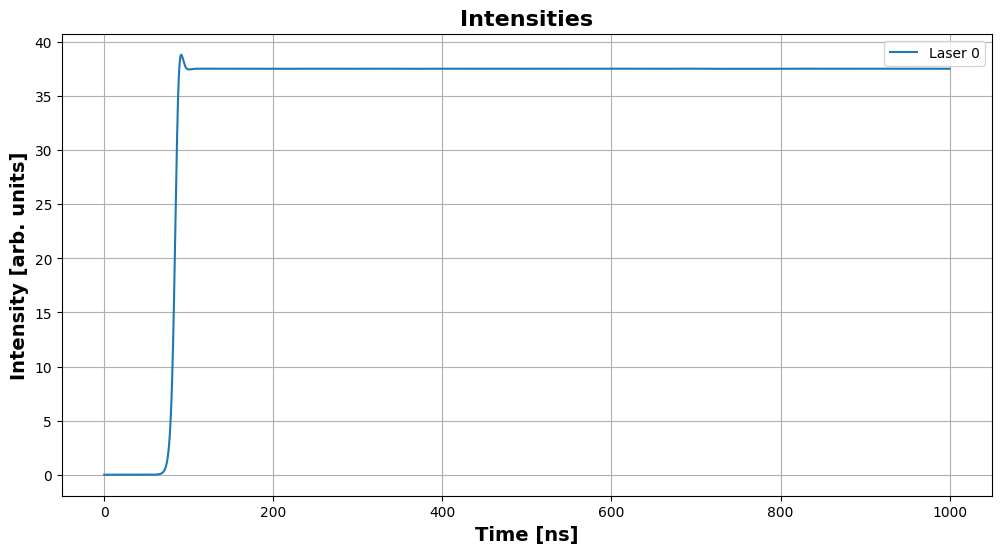

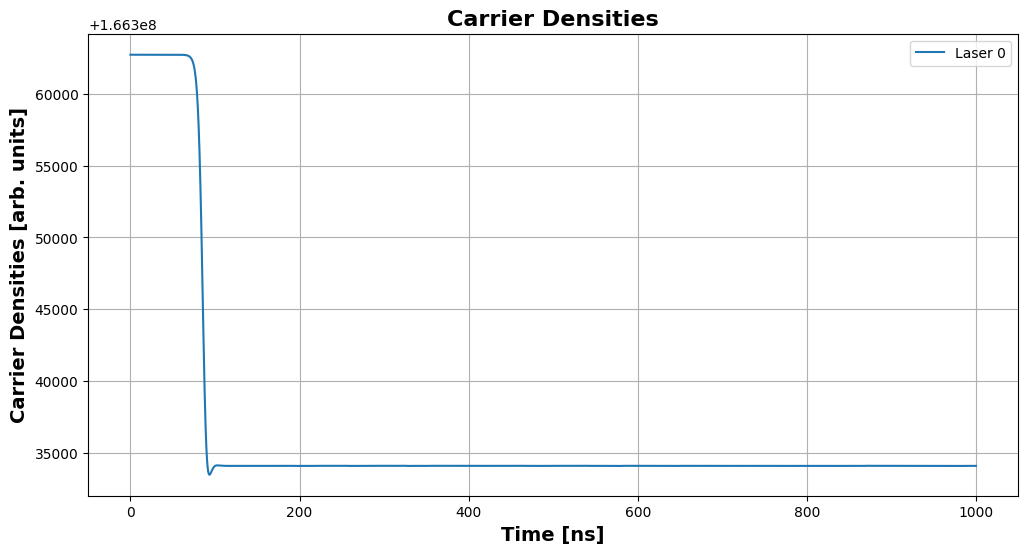

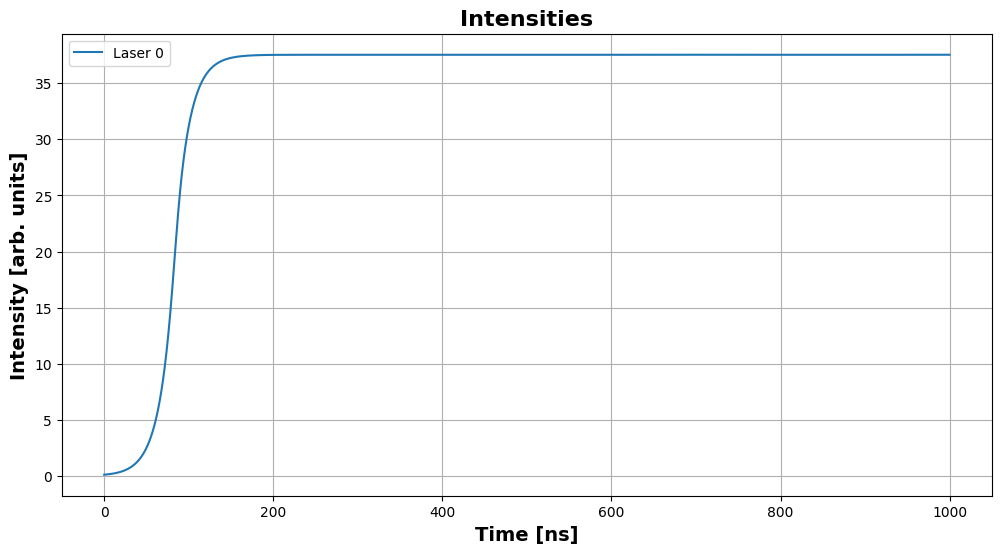

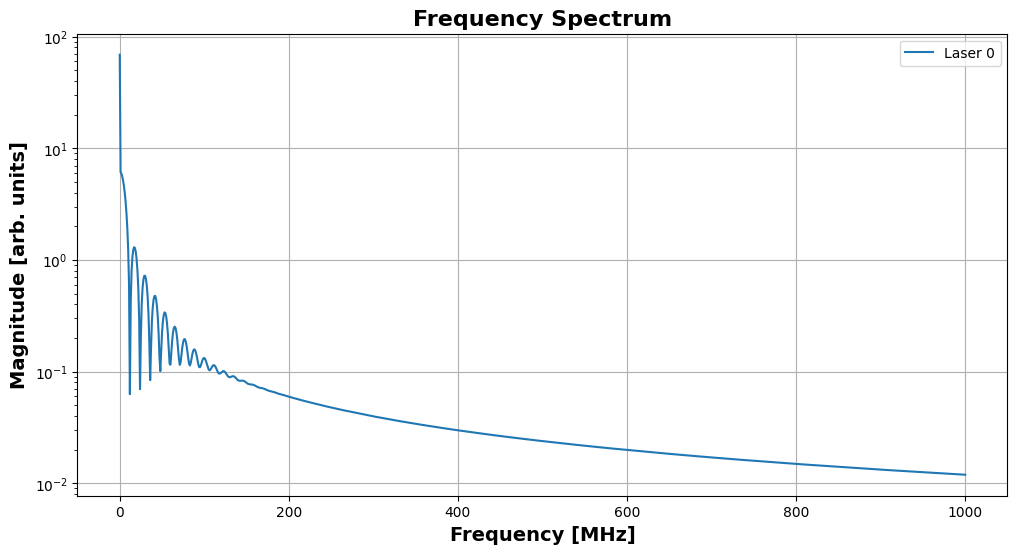

Avg normalized DC value of laser 0: 6.89e+01


In [23]:
plot_intensities(times, I_ts, filename="1laser_0kappa_0ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_0kappa_0ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_0kappa_0ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0kappa_0ns_threshold_intensity_fft.png")

### One Laser, Experiment #2: weak self-coupling, driving at threshold

In [13]:
# Set constants and ICs for a single, self coupled laser at threshold
kappas[0][0] = 0.01
taus[0][0] = 10e-9 # 10 ns self-couple delay
I_injections[0] = I_th

In [14]:
times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, t_start, t_end, dt, ics)

Generating, compiling, and loading C code.


/tmp/ipykernel_3817337/3362150922.py:23: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)


Finished solving system.


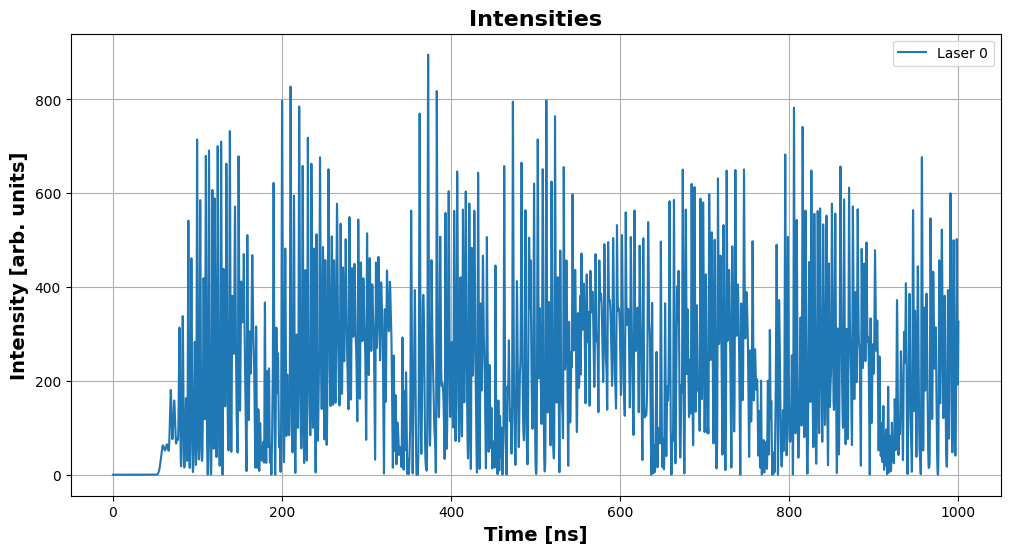

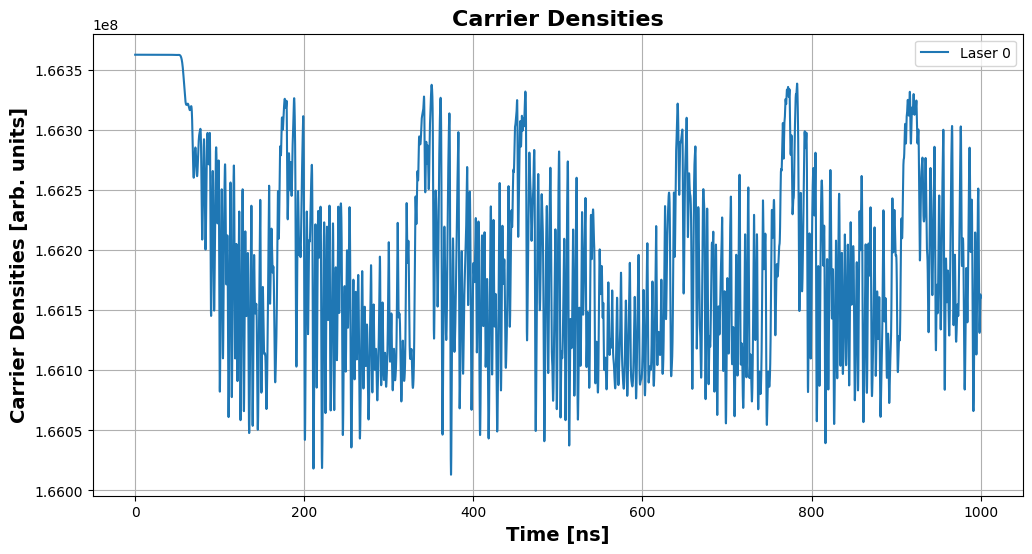

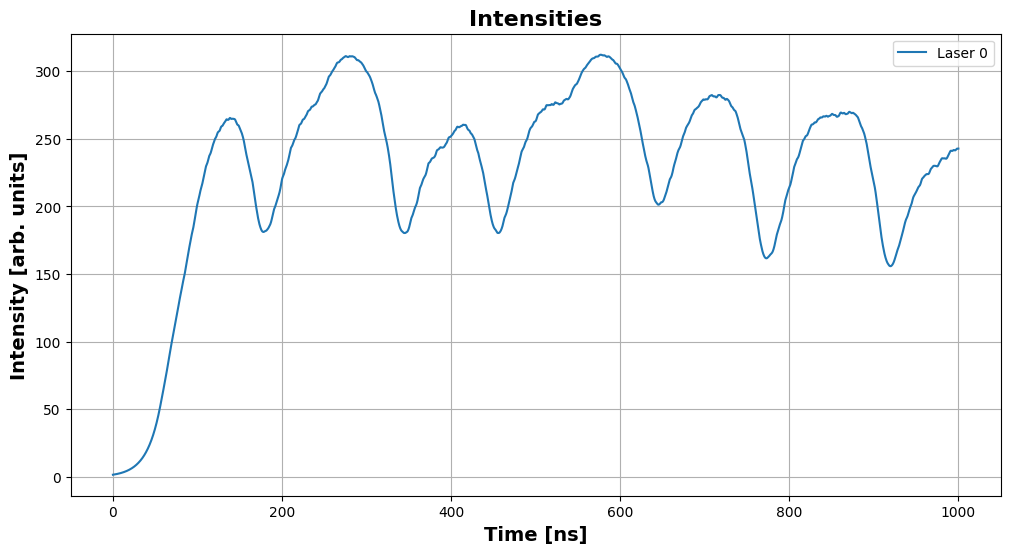

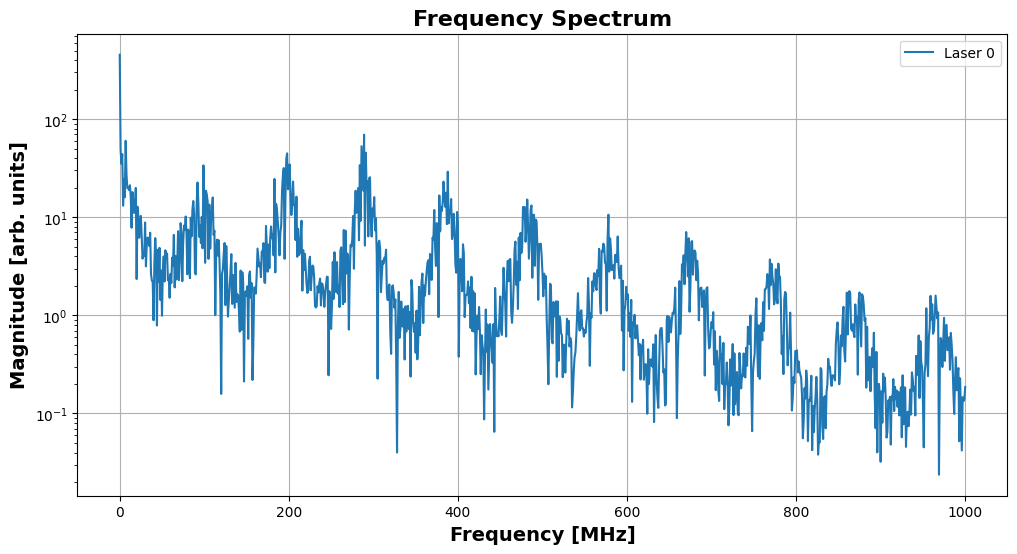

Avg normalized DC value of laser 0: 4.54e+02


In [15]:
plot_intensities(times, I_ts, filename="1laser_0p01kappa_10ns_threshold_intensity.png")
plot_carrier_densities(times, N_ts, filename="1laser_0p01kappa_10ns_threshold_carrierdensity.png")

filtered_I_ts = apply_lowpass_filter(I_ts, 1 / dt)
freqs, spectrums = take_fft(times, I_ts, dt)

plot_intensities(times, filtered_I_ts, filename="1laser_0p01kappa_10ns_threshold_intensity_filtered.png")
plot_fft_spectrum(freqs, spectrums, begin_freq=0, end_freq=1000, filename="1laser_0p01kappa_10ns_threshold_intensity_fft.png")

### One Laser, Experiment #3: Intensity vs. Current Curve

In [25]:
# Sweep injection current between 0mA to twice the threshold current
#start_current = 0
#end_current = 2 * I_th
#di = 1e-3 # 1mA steps

start_current = I_th - 2e-3
end_current = I_th + 2e-3
di = 0.04e-3 # 0.04mA steps

current_sweep = np.arange(start_current, end_current, di)

# No self-coupling
kappas[0][0] = 0
taus[0][0] = 0

intensity_sweep = []
# tqdm adds a progress bar
for current in tqdm(current_sweep):
    I_injections[0] = current
    times, I_ts, N_ts = simulate_system(num_lasers, omegas, kappas, taus, I_injections, t_start, t_end, dt, ics)

    # Record the laser's intensity at the end of the simulation when it has reached steady state
    intensity_sweep.append(I_ts[0][-1])

  0%|                                                      | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_3817337/409025556.py:23: UserWarning: The target time is smaller than the current time. No integration step will happen. The returned state will be extrapolated from the interpolating Hermite polynomial for the last integration step. You may see this because you try to integrate backwards in time, in which case you did something wrong. You may see this just because your sampling step is small, in which case there is no need to worry (though you should think about increasing your sampling time).
  state = dde.integrate(time)
100%|████████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]


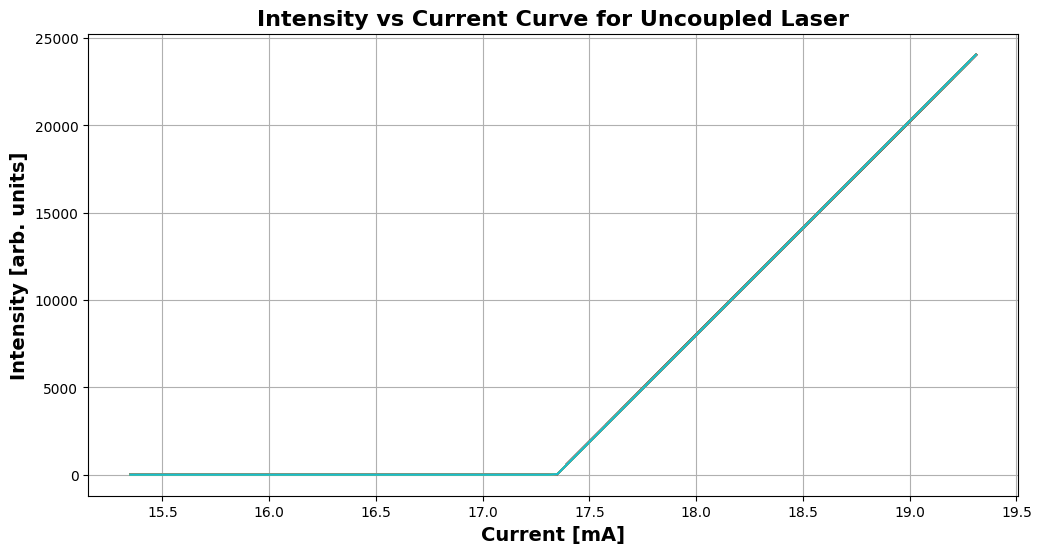

In [26]:
# Plot Intensity vs. Current curve
current_sweep_mA = current_sweep * 1e3

plt.figure(figsize=(12, 6))
for i in range(len(current_sweep_mA)):
    plt.plot(current_sweep_mA, intensity_sweep)
    #plt.plot(times_ns[(times_ns >= begin_time) & (times_ns <= end_time)], intensities[i][(times_ns >= begin_time) & (times_ns <= end_time)], label=f"Laser {i}")

plt.xlabel("Current [mA]", fontsize=14, fontweight='bold')
plt.ylabel("Intensity [arb. units]", fontsize=14, fontweight='bold')
plt.title("Intensity vs Current Curve for Uncoupled Laser",fontsize=16, fontweight='bold')
plt.grid(True)

plt.savefig("1laser_uncoupled_intensity_vs_current.png")
plt.show()

## Two Laser Simulations

In [98]:
# Two independent lasers, both biased at threshold
I_injections[0] = I_th
I_injections[1] = I_th

In [ ]:
# Two independent lasers, one biased above threshold, one biased below threshold
I_injections[0] = I_th + 1e-3
I_injections[1] = I_th - 1e-3

In [ ]:
# Two weakly coupled lasers, one biased above threshold, one biased below threshold
I_injections[0] = I_th + 1e-3
I_injections[1] = I_th - 1e-3

# Set coupling constants for 2 weakly inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.01
taus[0][1] = taus[1][0] = 10e-9

In [5]:
# Two intercoupled lasers both biased at threshold, one laser self-coupled
I_injections[0] = I_th
I_injections[1] = I_th

# Set coupling constants for 2 weakly inter-coupled lasers
kappas[0][1] = kappas[1][0] = 0.01
taus[0][1] = taus[1][0] = 10e-9

# Make laser #0 couple to itself too
kappas[0][0] = 0.01
taus[0][0] = 50e-9

In [99]:
# Initial conditions for 2 laser case (can be used for any of above cases)
E_R_0s = [1e-6, 1e-6]
E_I_0s = [0, 0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init, N_init]

# Introduce some asymmetry in initial conditions
E_R_0s[0] += 10e-6
E_R_0s[1] -= 10e-6

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])

## Three Laser Simulations

In [ ]:
# Set coupling constants for 3 independent, weakly self-coupled lasers
kappas[0][0] = 0.01
kappas[1][1] = 0.01
kappas[2][2] = 0.01

taus[0][0] = 3.65e-9
taus[1][1] = 3.65e-9
taus[2][2] = 3.65e-9

for row in kappas:
    print(row)

for row in taus:
    print(row)

In [212]:
# Set coupling constants for 3 weakly intercoupled coupled lasers
# Question: is kappa unitless or 1/s? (divided by tau_in?)
kappas[0][1] = kappas[1][0] = 1e7

taus[0][1] = taus[1][0] = 3.65e-9

for row in kappas:
    print(row)

for row in taus:
    print(row)

[0, 10000000.0, 0]
[10000000.0, 0, 0]
[0, 0, 0]
[0, 3.65e-09, 0]
[3.65e-09, 0, 0]
[0, 0, 0]


In [6]:
# Observe changes in injection current (3 independent lasers)
#I_injections = [I_th + 10e-3 for x in I_injections]
I_injections[1] += 1e-3
I_injections[2] += 10e-3

print(I_injections)

[0.01735, 0.01835, 0.02735]


In [8]:
# Set INITIAL CONDITIONS required for DDE solver
# Initial conditions for 3 laser case
E_R_0s = [1e-6, 1e-6, 1e-6]
E_I_0s = [0, 0, 0]
N_init = N_0 + (I_th / e_charge - gamma_e * N_0) / gamma_e
N_0s = [N_init, N_init, N_init]

# Introduce some asymmetry in initial conditions
#E_R_0s[1] += 10e-6
#E_R_0s[2] -= 10e-6

ics = []
for i in range(num_lasers):
    ics.append(E_R_0s[i])
    ics.append(E_I_0s[i])
    ics.append(N_0s[i])